In [1]:
import os
from openai import OpenAI
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from pathlib import Path
import json
import re
import base64
from PIL import Image

In [2]:
load_dotenv(override=True)

True

In [3]:
openai_api_key = os.getenv("openai_api_key")
if openai_api_key:
    print("Yay got the key!!")

Yay got the key!!


In [4]:
openai = OpenAI()
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [5]:
def query_agent(data, query):
    """
    Query Checker Agent - verifies if requested columns exist in dataset
    """
    system_prompt1 = """
Role:
You are a Query Checker Agent. Your sole job is to verify if the user's request involves columns
that are present in the dataset provided.

Behavior:
- Read the user query and identify column names that may be mentioned (like 'sales', 'profit', etc.)
- Match those with the dataset's column headers.
- If ALL required columns exist in the dataset, return: yes
- If ANY column is missing, return: no

Constraints:
- Your response must be exactly one word: yes or no
- No extra text, no explanation

Example:
Dataset columns: ['region', 'sales', 'profit', 'discount']
Query: "Plot sales vs profit by region"
→ Output: yes
"""
    dataset_info = f"Dataset columns: {list(data.columns)}\nSample data:\n{data.head().to_string()}"
    output = openai.chat.completions.create(
        model = MODEL,
        messages = [
            {"role":"system", "content":system_prompt1},
            {"role":"user", "content":f"""
Dataset:
{dataset_info}

User Prompt:
{query}
"""}
        ] 
    )
    return output.choices[0].message.content.strip().lower()

In [6]:
def coder_agent(data, query):
    """
    Coder Agent - generates matplotlib visualization code
    """
    system_prompt2 = """
Role:
You are an advanced visualization agent that writes Python code using the matplotlib library
to generate insightful visualizations. Whether it's bar charts, pie charts, histograms, or line charts,
you can code and modify them all effectively based on the user's query and data.

Constraints:
- You must not include plt.show() in the generated code. 
- Instead, end the code with plt.savefig("my_generated_plot.png", dpi=300, bbox_inches='tight')
- Do not use seaborn, plotly, or any other libraries—only matplotlib and pandas.
- The code must be valid Python and executable without modification.
- The data is available as a pandas DataFrame named 'data'
- Return ONLY the executable Python code, no markdown formatting, no explanations

Input Example:
Data: A pandas DataFrame with various columns
Query: "Plot a bar chart of sales by product category."

Output:
Only the Python code that uses matplotlib to generate the specified visualization.

Format:
Return only the raw Python code—no ```python```, no explanations, comments are fine within code.
"""

    dataset_info = f"Dataset columns: {list(data.columns)}\nDataset shape: {data.shape}\nSample data:\n{data.head().to_string()}"
    
    response = openai.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": system_prompt2},
            {"role": "user", "content": f"""
Dataset:
{dataset_info}

User Prompt:
{query}
"""}
        ]
    )
    
    code = response.choices[0].message.content.strip()
    if code.startswith("```python"):
        code = code[9:]
    if code.startswith("```"):
        code = code[3:]
    if code.endswith("```"):
        code = code[:-3]

    return code.strip()

In [7]:
def insights_agent(image_path, query):
    try:
        with open(image_path,"rb") as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
        
        image_data_url = f"data:image/png;base64,{encoded_image}"

        response = openai.chat.completions.create(
            model = "gpt-4o",
            messages = [
                {
                    "role":"user",
                    "content":[
                        {
                            "type":"text",
                            "text":f"Analyze this visualization that was created based on this query:'{query}'. What insights can you draw from thi graph? Provide a detailed analysis of the patterns, trends and key findings."
                        },
                        {
                            "type":"image_url",
                            "image_url":{"url":image_data_url}
                        }
                    ]
                }
            ],
            max_tokens = 600
        )
        insights = response.choices[0].message.content
        return insights
    
    except Exception as e:
        return f"Error getting insights: {str(e)}"


In [13]:
def display_image(image_path):
    try:
        img = Image.open(image_path)
        #display(img)
        return img
    except Exception as e:
        print(f"Error displaying image:{str(e)}")
        return None

In [14]:
def central_controller(file_path, query):
    """
    Central Controller - orchestrates the multi-agent system
    """
    try:
        file_extension = Path(file_path).suffix.lower()
        
        if file_extension == '.csv':
            data = pd.read_csv(file_path)
        elif file_extension in ['.xlsx', '.xls']:
            try:                
                data = pd.read_excel(file_path, engine='openpyxl')
            except ImportError:
                raise ImportError(
                    "Missing required dependency 'openpyxl' for Excel files. "
                    "Please install it using: pip install openpyxl"
                )
            except Exception as e:
                try:
                    data = pd.read_excel(file_path, engine='xlrd')
                except ImportError:
                    raise ImportError(
                        "Missing required dependency for Excel files. "
                        "Please install: pip install openpyxl xlrd"
                    )
                except Exception as e2:
                    raise Exception(f"Error reading Excel file: {str(e2)}")
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")
            
        print(f"Data loaded successfully. Shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")
        
    except Exception as e:
        return f"Error reading file: {str(e)}", None
    
    print("Checking query validity...")
    extracted_query = query_agent(data, query)
    
    if extracted_query == "no":
        return "The attributes you are looking for are not present in the dataset!!", None
    
    print("Query is valid. Generating visualization...")
    
    try:
        generated_code = coder_agent(data, query)
        print("Generated code:")
        print(generated_code)
        print("\nExecuting visualization code...")
        
        exec_globals = {'data': data, 'plt': plt, 'pd': pd, 'np': np}
        exec(generated_code, exec_globals)
        
        print("Visualization saved as 'my_generated_plot.png'")
        
    except Exception as e:
        return f"Error generating visualization: {str(e)}", None
    
    print("Generating insights...")
    try:
        insights_generated = insights_agent("my_generated_plot.png", query)
        img = display_image("my_generated_plot.png")
        print("Displaying final visualization....")
        display(img)
        
        return insights_generated,img
    
    except Exception as e:
        return f"Error generating insights: {str(e)}", None


In [18]:
file_path = r"C:\Users\KIIT\Desktop\LLM Engineering\projects\llm_engineering\week5\sample_sales_data.csv"
query = "Show me the relationship betwen Category and Sales through a bar chart"

Data loaded successfully. Shape: (20, 8)
Columns: ['Date', 'Region', 'Product', 'Category', 'Sales', 'Profit', 'Discount', 'Quantity']
Checking query validity...
Query is valid. Generating visualization...
Generated code:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is a pandas DataFrame with the relevant data
category_sales = data.groupby('Category')['Sales'].sum().reset_index()

plt.bar(category_sales['Category'], category_sales['Sales'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product Category')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("my_generated_plot.png", dpi=300, bbox_inches='tight')

Executing visualization code...
Visualization saved as 'my_generated_plot.png'
Generating insights...
Displaying final visualization....


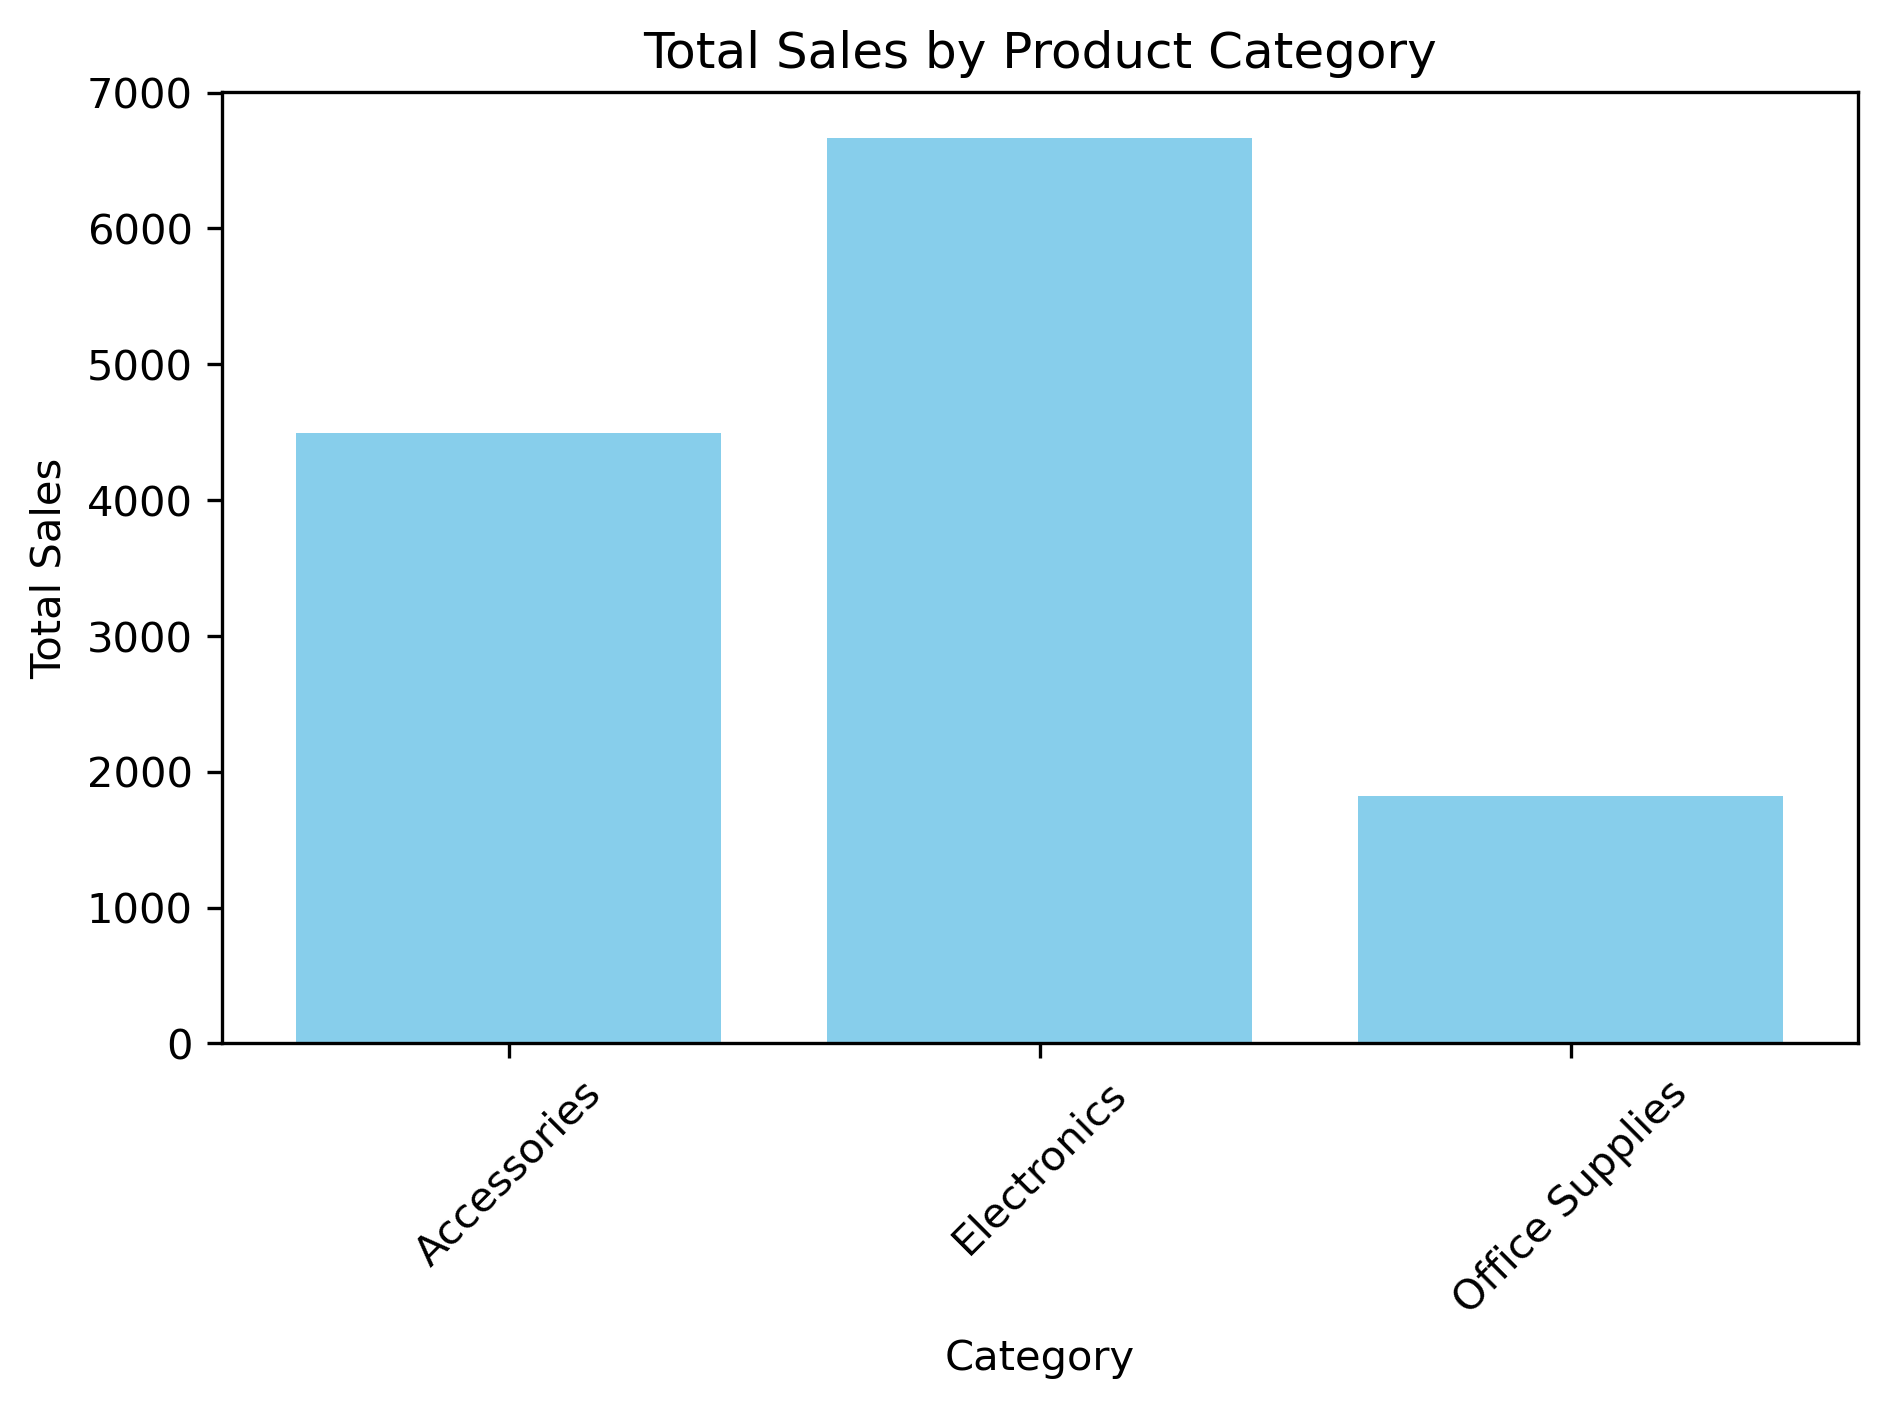


INSIGHTS:


The bar chart presents the total sales for three product categories: Accessories, Electronics, and Office Supplies. Here are some insights and analysis:

### Patterns and Trends

1. **Dominance of Electronics:**
   - Electronics category has the highest sales, reaching above 6,000 units. This indicates a strong consumer demand or higher-value sales in this category.

2. **Moderate Sales for Accessories:**
   - Accessories have sales slightly over 4,000 units. This category performs moderately well, suggesting it has a stable market.

3. **Low Sales for Office Supplies:**
   - Office Supplies have the lowest sales, below 2,000 units. This could indicate lower demand or lower pricing per item in this category.

### Key Findings

1. **Sales Distribution:**
   - Electronics capture the largest share of sales compared to the other categories, signifying its importance in the overall sales strategy.

2. **Potential Growth Areas:**
   - Given the lower sales figures, Office Supplies might represent an opportunity for growth through marketing strategies or diversification.

3. **Balanced Portfolio:**
   - While Electronics drives the majority of sales, having significant sales in Accessories ensures some balance and reduced risk against market volatility in a single category.

### Recommendations

1. **Focus on Electronics:**
   - Continue to leverage the Electronics category, possibly expanding the product range or enhancing promotional activities to maximize revenue.

2. **Boost Accessories Market:**
   - Explore targeted marketing and bundling opportunities to increase sales in the Accessories category.

3. **Revitalize Office Supplies:**
   - Investigate the reasons behind lower sales in Office Supplies. Consider promotions, new product launches, or tapping into new market segments to improve performance.

This analysis highlights the strengths and potential areas for improvement in sales strategies across different categories.

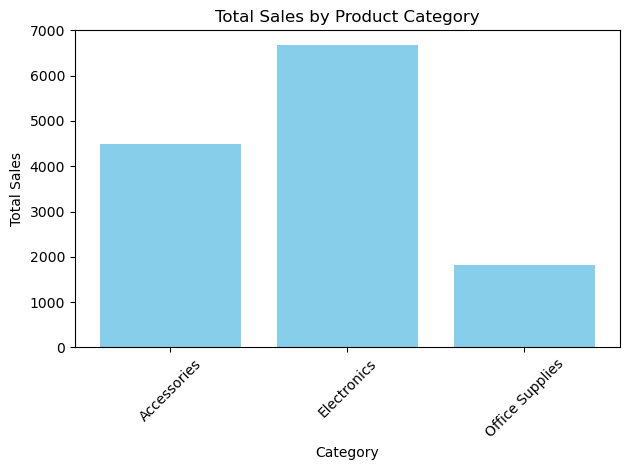

In [19]:
insights,image = central_controller(file_path, query)
print("\n" + "="*50)
print("INSIGHTS:")
print("="*50)
display(Markdown(insights))